In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

REPO_NAME = 'sewer-nfl'
CWD = str(os.getcwd())
REPO_DIR = CWD[:CWD.find(REPO_NAME)+len(REPO_NAME)]
sys.path.insert(0,REPO_DIR)

In [5]:
REGEN = False
if REGEN:
    from models._utilities.data.pipe_layer import build_training_dataset
    from warehouse.config import Configuration # At model level, swictch this to model's config
    config = Configuration()
    t = build_training_dataset(config)
else: t = build_training_dataset()

Using cache


Fitting 3 folds for each of 1 candidates, totalling 3 fits


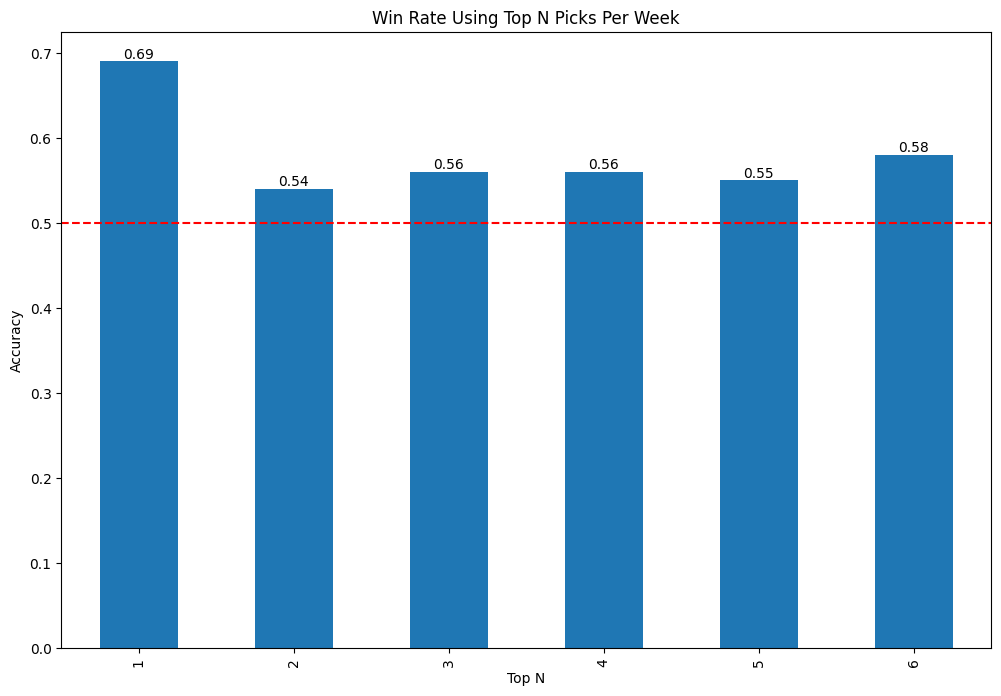

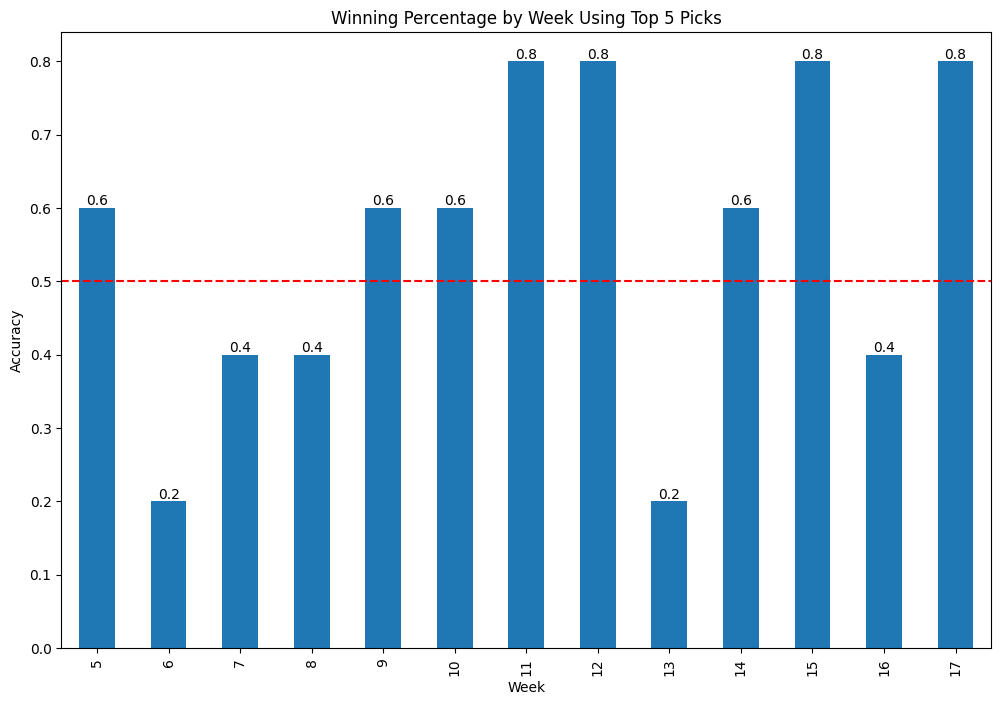

In [9]:
from models._utilities.model.sewer_boost import Model
m1 = Model(
    training_data = t
)
m1.get_test_accuracy_drop_off()
m1.get_test_accuracy_by_week()

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster='gbtree',
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     gamma=None, gpu_id=None,
                                     grow_policy='lossguide',
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learnin...
                         'max_cat_threshold': [None],
                         'max_cat_to_onehot': [None], 'max_delta_step': [None],
                         'max_depth': [None], 'max_leaves': [None],
                         'min_child_weight': [None], 'missing': [nan],
                         'monotone_constraints': [None], 'n_estimators': [100],
                         'n_jobs': [None], 'num_parallel_tree': [None],
                         'objective': ['binary:logistic'], 'predictor': [None], ...},
             return_train_score=True, scoring='accuracy', verbose=1)